# [vk sim](https://github.com/pachterlab/varseek) demonstration with multiple conditions, and performance of varseek on this dataset - used for Fig2 of our manuscript

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek

In [2]:
import random
import varseek as vk
import os
import sys
import anndata as ad
import subprocess
import numpy as np
from datetime import datetime
import shutil
import pickle
from pathlib import Path
import pandas as pd
import json
# from tqdm import tqdm
# tqdm.pandas()

from varseek.utils import build_random_genome_read_df, calculate_metrics, create_stratified_metric_bar_plot, create_venn_diagram, plot_histogram, draw_confusion_matrix, make_bus_df_original, download_ensembl_reference_files, safe_literal_eval, add_vcrs_variant_type
varseek_directory = os.path.dirname(os.path.abspath(""))

## Define parameters and paths

In [ ]:
number_of_variants_to_sample_per_condition = 350

read_length = 150
strand = "random"  # None for strand-agnostic (randomly-selected), "f" for forward, "r" for reverse, "both" for both - make sure this matches the reference genome (vk build command) - strand = True -> "f" or "r" here; strand = False -> None or "both" here - note that the strand is randomly selected per *transcript*, such that all drawn reads will come from the same strand no matter what
add_noise_sequencing_error=True
add_noise_base_quality=False
error_rate=0.001  # only if add_noise_sequencing_error=True
error_distribution=(0.85, 0.1, 0.05)  # sub, del, ins  # only if add_noise_sequencing_error=True
max_errors=float("inf")  # only if add_noise_sequencing_error=True
seq_id_column="seq_ID"
var_column="mutation_cdna"
threads = 4
check_reason_for_read_fn = False
check_reason_for_ref_fn = False
seed=42
random_file_suffix = "most_recent"  # None for no random file, or suffix (in datetime format) for random file, or "most_recent" for most recent random file

number_of_random_reads_cdna = 10000
number_of_random_reads_genome = 0

k = 51
w = 47

# Paths
vk_ref_out_dir = os.path.join(varseek_directory, "data", "vk_ref_out")
reference_out_dir = os.path.join(varseek_directory, "data", "reference")
sequences = os.path.join(reference_out_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")
reference_genome_fasta = os.path.join(reference_out_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.dna.primary_assembly.fa")
out_dir_notebook = os.path.join(varseek_directory, "data", "simulated_data_output")  #!!! change for each run

bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"

In [4]:
if not os.path.exists(sequences) or not os.path.exists(reference_genome_fasta):
    grch37_reference_dir = os.path.join(reference_out_dir, "ensembl_grch37_release93")
    reference_genome_fasta, sequences, _ = download_ensembl_reference_files(grch37_reference_dir, grch=37, ensembl_release=93)

In [ ]:
if not os.path.exists(vk_ref_out_dir):
    varseek_directory = os.path.dirname(os.path.abspath(""))
    run_vk_ref_script_path = os.path.join(varseek_directory, "scripts", "run_vk_ref_cosmic.py")
    subprocess.run(["python3", run_vk_ref_script_path], check=True)
    w, k = 47, 51

In [6]:
mutation_metadata_df = os.path.join(vk_ref_out_dir, "variants_updated_exploded_filtered.csv")
mutation_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
mutation_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")

out_dir_vk_build = f"{out_dir_notebook}/vk_build"

synthetic_reads_fastQ = f"{out_dir_notebook}/synthetic_reads.fq"
specific_fastq_selection = f"{out_dir_notebook}/specific_fastq_collection"
os.makedirs(specific_fastq_selection, exist_ok=True)
random_reads_fastq_cdna = f"{specific_fastq_selection}/random_reads_cdna.fq"
random_reads_fastq_genome = f"{specific_fastq_selection}/random_reads_genome.fq"
read_df_out = f"{out_dir_notebook}/synthetic_reads.csv"
mutation_metadata_df_out = f"{out_dir_notebook}/mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv"
# config_file_out = f"{out_dir_notebook}/vk_sim_config.json"

vk_count_out_dir = f"{out_dir_notebook}/vk_count_out_dir"
kb_count_out = f"{vk_count_out_dir}/kb_count_out_vcrs"

read_df = None
mutation_metadata_df_path = mutation_metadata_df

read_df_out_updated = read_df_out.replace(".csv", "_updated.csv")
unique_mcrs_df_out = f"{out_dir_notebook}/unique_mcrs_df.csv"

plot_output_folder = f"{out_dir_notebook}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

read_df_did_not_exist = False

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
if random_file_suffix == "most_recent":
    # List and sort pickle files by filename (descending)
    sorted_pickle_files = sorted(
        Path(out_dir_notebook).glob("*.pkl"),
        key=lambda p: p.name,
        reverse=True
    )
    if sorted_pickle_files:
        random_file_suffix = str(sorted_pickle_files[0]).split("__")[-1].split(".")[0]
    else:
        random_file_suffix = None
if random_file_suffix is None:
    random_file_suffix = current_time

random_state_path = os.path.join(out_dir_notebook, f"random_state__{random_file_suffix}.pkl")
numpy_random_state_path = os.path.join(out_dir_notebook, f"numpy_random_state__{random_file_suffix}.pkl")

def load_in_random_states(random_state_path=None, numpy_random_state_path=None, verbose=False):
    if random_state_path and os.path.exists(random_state_path):
        if verbose:
            print(f"Loading random state from {random_state_path}")
        with open(random_state_path, "rb") as f:
            random_state = pickle.load(f)
            random.setstate(random_state)
    if numpy_random_state_path and os.path.exists(numpy_random_state_path):
        if verbose:
            print(f"Loading numpy random state from {numpy_random_state_path}")
        with open(numpy_random_state_path, "rb") as f:
            numpy_random_state = pickle.load(f)
            np.random.set_state(numpy_random_state)

def save_random_states(random_state_path=None, numpy_random_state_path=None, verbose=False):
    if random_state_path:
        if verbose:
            print(f"Saving random state to {random_state_path}")
        with open(random_state_path, "wb") as f:
            random_state = random.getstate()
            pickle.dump(random_state, f)
    if numpy_random_state_path:
        if verbose:
            print(f"Saving numpy random state to {numpy_random_state_path}")
        with open(numpy_random_state_path, "wb") as f:
            numpy_random_state = np.random.get_state()
            pickle.dump(numpy_random_state, f)

if seed:
    random.seed(seed)
    np.random.seed(seed)

# Synthetic read FASTQ generation

In [8]:
# # uncomment for debugging
# number_of_variants_to_sample_per_condition = 5
# m_list = [4, 6]
# w_list = [1, 3]
# conditions = ['variant_type:equal=substitution']

m_list = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
conditions = ['variant_type:equal=substitution', 'variant_type:not_equal=substitution', 'kmer_overlap_with_other_VCRSs:is_false', 'kmer_overlap_with_other_VCRSs:is_true', 'is_near_splice_junction_10:is_false', 'is_near_splice_junction_10:is_true']

number_of_conditions = len(conditions) * len(m_list) * len(w_list)
print(f"Number of conditions: len(conditions) * len(m_list) * len(w_list) = {number_of_conditions}")

random.shuffle(m_list)
random.shuffle(w_list)

i = 0
first_iteration = True
if not os.path.exists(mutation_metadata_df_out) or not os.path.exists(read_df_out):
    read_df_did_not_exist = True
    for mutant_sequencing_depth in m_list:
        for wt_sequencing_depth in w_list:
            for condition in conditions:
                read_fq_path_specific = f"{specific_fastq_selection}/synthetic_reads_m{mutant_sequencing_depth}_w{wt_sequencing_depth}_{condition.replace('=', '_')}.fq"
                condition_added_list = [condition, 'included_in_synthetic_reads:is_not_true']
                
                print(f"i = {i+1} / {number_of_conditions} - mutant_sequencing_depth = {mutant_sequencing_depth}, wt_sequencing_depth = {wt_sequencing_depth}, condition = {condition}")

                load_in_random_states(random_state_path, numpy_random_state_path)

                if not os.path.exists(read_fq_path_specific):
                    simulated_df_dict = vk.sim(
                        variants=mutation_metadata_df,
                        reads_fastq_parent=synthetic_reads_fastQ,
                        reads_csv_parent=read_df,
                        number_of_variants_to_sample=number_of_variants_to_sample_per_condition,
                        strand=strand,
                        number_of_reads_per_variant_alt=mutant_sequencing_depth,
                        number_of_reads_per_variant_ref=wt_sequencing_depth,
                        k=k,
                        w=w,
                        read_length=read_length,
                        seed=None,  # no need to pass in since it's set globally
                        add_noise_sequencing_error=add_noise_sequencing_error,
                        error_rate=error_rate,
                        error_distribution=error_distribution,
                        max_errors=max_errors,
                        with_replacement=False,  # set to True if wanting to have some reads that might be identical
                        sequences=sequences,
                        seq_id_column=seq_id_column,
                        var_column=var_column,
                        var_id_column="header",
                        variant_type_column="vcrs_variant_type",
                        reference_out_dir=reference_out_dir,
                        filters=condition_added_list,
                        out=out_dir_notebook,
                        reads_fastq_out=read_fq_path_specific,
                        reads_csv_out=None,  # left as None so that I don't have to save upon each iteration - instead, I just save at the end
                        variants_updated_csv_out=None,  # left as None so that I don't have to save upon each iteration - instead, I just save at the end
                        make_internal_copies=False,  # since I am ok modifying the original mutation_metadata_df and read_df, I don't need to make internal copies of these
                        filter_null_rows_from_important_cols=first_iteration  # removes this filtering step from each iteration
                    )
                    mutation_metadata_df, read_df = simulated_df_dict['variants'], simulated_df_dict['read_df']
                    if first_iteration:
                        mutation_metadata_df = mutation_metadata_df.dropna(subset=['mutant_sequence_read_parent', 'wt_sequence_read_parent'])
                    random_state_path = os.path.join(out_dir_notebook, f"random_state__{current_time}.pkl")
                    numpy_random_state_path = os.path.join(out_dir_notebook, f"numpy_random_state__{current_time}.pkl")
                    save_random_states(random_state_path, numpy_random_state_path)
                else:
                    print(f"File {read_fq_path_specific} already exists, skipping simulation for this condition.")

                first_iteration = False
                print(f"Completeted i = {i+1}/{number_of_conditions}")
                i += 1

    read_df.to_csv(read_df_out, index=False)
    mutation_metadata_df.to_csv(mutation_metadata_df_out, index=False)
else:
    read_df = pd.read_csv(read_df_out)
    mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

Number of conditions: len(conditions) * len(m_list) * len(w_list) = 1092


/tmp/ipykernel_3685788/3058260878.py:80: DtypeWarning: Columns (11,12,13,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)


# Add portions of the reference genome and transcriptome (regions unrelated to any of the variants above)

In [10]:
if read_df_did_not_exist:
    if number_of_random_reads_cdna > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = sequences, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_cdna, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_cdna, read_length = read_length, input_type = "transcriptome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)  # no need to pass in since it's set globally
    if number_of_random_reads_genome > 0:
        read_df = build_random_genome_read_df(reference_fasta_file_path = reference_genome_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, read_df_out=read_df_out, fastq_output_path = random_reads_fastq_genome, fastq_parent_path = synthetic_reads_fastQ, n = number_of_random_reads_genome, read_length = read_length, input_type = "genome", strand = strand, add_noise_sequencing_error=add_noise_sequencing_error, add_noise_base_quality=add_noise_base_quality, seed=None)

## Run varseek count on the synthetic data
- Although we will not count multimapped reads in our alignment, we will run kb count with `--mm` in order to understand which reads multimapped for our own knowledge

In [12]:
if not os.path.exists(vk_count_out_dir) or len(os.listdir(vk_count_out_dir)) == 0:
    vk.count(
        synthetic_reads_fastQ,
        index=mutation_index,
        t2g=mutation_t2g,
        technology="bulk",
        out=vk_count_out_dir,
        k=k,
        threads=threads,
        mm=True,
        union=False,
        num=True,
        parity="single",
        disable_fastqpp=True,
        disable_clean=True,
        disable_summarize=True
    )

## View run_info.json to get an idea of our alignment

In [13]:
!cat {kb_count_out}/run_info.json | grep -E '"n_targets"|"n_processed"|"n_pseudoaligned"|"n_unique"|"p_pseudoaligned"|"p_unique"'

with open(f"{kb_count_out}/run_info.json", 'r', encoding="utf-8") as f:
    data = json.load(f)

total_reads = data.get("n_processed", None)
n_pseudoaligned = data.get("n_pseudoaligned", None)
n_unique = data.get("n_unique", None)
n_multimapped = n_pseudoaligned - n_unique

	"n_targets": 5345528,
	"n_processed": 30174400,
	"n_pseudoaligned": 15554795,
	"n_unique": 15537954,
	"p_pseudoaligned": 51.5,
	"p_unique": 51.5,


## Convert our BUS file into a dataframe that is easier to work with

In [14]:
bus_df_path = f"{kb_count_out}/bus_df.csv"
if not os.path.exists(bus_df_path):
    bus_df = make_bus_df_original(kallisto_out = kb_count_out, fastq_file_list = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = False, union = False, technology = "bulk", bustools = bustools)
else:
    bus_df = pd.read_csv(bus_df_path)
bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

/tmp/ipykernel_3685788/1979469476.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  bus_df = pd.read_csv(bus_df_path)


# Benchmarking varseek - perspective of reads

### Check if the read aligned anywhere

In [15]:
if not "vcrs_variant_type" in read_df.columns or read_df['vcrs_variant_type'].isna().values.all():
    read_df = add_vcrs_variant_type(read_df, var_column="vcrs_header")

TP: 15542770, FP: 12020, FN: 98030, TN: 14521580
Accuracy: 0.9963528686568747, Sensitivity: 0.9937324177791418, Specificity: 0.9991729509550283


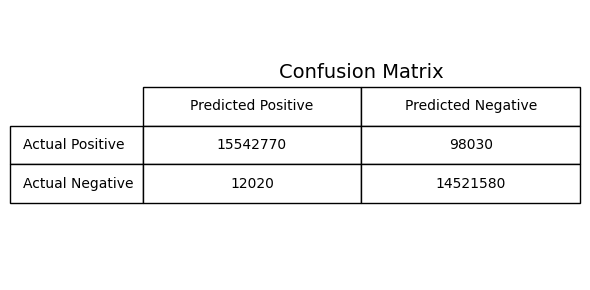

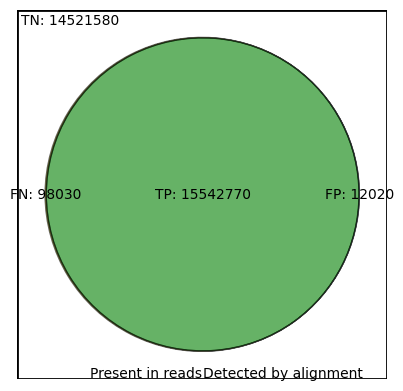

In [ ]:
aligned_ids = set(bus_df['read_id'])
read_df['aligned_somewhere'] = read_df['read_id'].isin(aligned_ids)

read_df['TP_crude'] = (read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FP_crude'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FN_crude'] = (read_df['mutant_read'] & ~read_df['aligned_somewhere'])
read_df['TN_crude'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])

read_df['read_id_unique'] = read_df['read_id'] + "_" + read_df.index.astype(str)  # because, if I sample with replacement, some read_id's (and their matching read_header's) will be repeated

metric_dictionary_reads_crude = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = False, crude = True, out = f"{plot_output_folder}/reads_metrics_crude.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reads_crude)

true_set_crude = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set_crude = set(read_df.loc[read_df['aligned_somewhere'], 'read_id_unique'])
# don't show mm here, because mm is counted as a TP for crude
create_venn_diagram(true_set_crude, positive_set_crude, TN = metric_dictionary_reads_crude['TN'], mm = None, out_path = f"{plot_output_folder}/venn_diagram_read_crude.png")

### Check if the read aligned to its correct VCRS
In much of the varseek documentation, we refer to variant-containing reference sequences (VCRSs). Because COSMIC is a mutation database, we use the acronym MCRS, for mutation-containing reference sequences. We use the terms MCRS and VCRS interchangeably in the context of databases where the variants are, in fact, mutations, such as with COSMIC.

In [ ]:
# so that the drop_duplicates() doesn't throw an error
bus_df['transcript_ids_list'] = bus_df['transcript_ids_list'].astype(str)
bus_df['transcript_names_final'] = bus_df['transcript_names_final'].astype(str)

# Merge read_df with bus_df on 'read_id' and 'fastq_header' to bring in 'transcript_ids_list'
read_df = read_df.merge(bus_df[['read_id', 'transcript_ids_list', 'transcript_names_final']].drop_duplicates(), 
                          on='read_id', 
                          how='left').rename(columns={'transcript_names_final': 'mcrs_header_to_which_the_read_aligned'})

read_df["transcript_ids_list"] = read_df["transcript_ids_list"].apply(safe_literal_eval)

# Create 'multimapped' column as True if length of 'transcript_ids_list' > 1, else False
read_df['multimapped'] = read_df['transcript_ids_list'].apply(lambda x: len(x) > 1 if isinstance(x, list) else False)

read_df.drop(columns=['transcript_ids_list'], inplace=True)

read_df["mcrs_header_to_which_the_read_aligned"] = read_df["mcrs_header_to_which_the_read_aligned"].apply(safe_literal_eval)

# Convert lists to comma-separated strings, keeping NaN values as NaN
read_df['mcrs_header_to_which_the_read_aligned'] = read_df['mcrs_header_to_which_the_read_aligned'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

In [ ]:
read_df['aligned_to_correct_mcrs'] = (read_df['vcrs_header'] == read_df['mcrs_header_to_which_the_read_aligned'])

# Check if 'vcrs_id' is a substring of any item in 'mcrs_header_to_which_the_read_aligned'
read_df['aligned_to_correct_mcrs_including_multimapped'] = read_df.apply(
    lambda row: row['vcrs_header'] in row['mcrs_header_to_which_the_read_aligned'] 
                if isinstance(row['mcrs_header_to_which_the_read_aligned'], str) else False,
    axis=1
)

read_df['TP'] = (read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FP'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])  # same as "FP_crude" (because I don't care if a WT read mapped to its respective MCRS or another MCRS - either way, if it aligns anywhere, it is a FP)
read_df['FN'] = (read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])
read_df['TN'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])  # same as "TN_crude" (because I don't care if a WT read mapped to its respective MCRS or another MCRS - either way, if it aligns anywhere, it is a FP)

metric_dictionary_reads = calculate_metrics(read_df, header_name = "read_id_unique", check_assertions = False, out = f"{plot_output_folder}/read_metrics.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reads)

true_set = set(read_df.loc[read_df['mutant_read'], 'read_id_unique'])
positive_set = set(read_df.loc[read_df['aligned_to_correct_mcrs'], 'read_id_unique'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reads['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read.png")  # the FPs/TNs of this Venn will be off (it uses aligned_to_correct_mcrs instead of aligned_somewhere)

# stratify by variant type
create_stratified_metric_bar_plot(read_df, 'vcrs_variant_type', 'accuracy', overall_metric = metric_dictionary_reads_crude['accuracy'], log_x_axis = False, display_numbers = True, crude = False, out_path = f"{plot_output_folder}/accuracy_vs_vcrs_variant_type_read_perspective.png")

### Check reasons for read false negatives - can take a long time for a large number of FNs 

In [ ]:
read_df['reason_for_fn'] = np.nan

if check_reason_for_read_fn:
    # Loop through each row in read_df where 'FN' is True
    for index, row in read_df.loc[read_df['FN']].iterrows():
        reason_for_fn_sublist = []

        # Get the vcrs_id from the current row in read_df
        vcrs_id = row['vcrs_id']
        
        # Find the corresponding vcrs_sequence_length in mutation_metadata_df
        matching_length = mutation_metadata_df.loc[
            mutation_metadata_df['vcrs_id'] == vcrs_id, 'vcrs_sequence_length'
        ]
        
        # Check if there's a match and if the length is less than 2*k-1
        if not matching_length.empty and matching_length.iloc[0] < (2*k-1):
            reason_for_fn_sublist.append("short_mcrs_id")

        if row['multimapped']:
            reason_for_fn_sublist.append("multimapped")
        
        dlist_status = mutation_metadata_df.loc[
            mutation_metadata_df['vcrs_id'] == vcrs_id, 'alignment_to_reference'
        ]

        if not dlist_status.empty and dlist_status.iloc[0] != "none":
            reason_for_fn_sublist.append("dlisted")

        if reason_for_fn_sublist:
            read_df.at[index, 'reason_for_fn'] = reason_for_fn_sublist  # might be cast as a string if length == 1 (especially for first row), but this doesn't really matter for me

    num_nan_reasons = read_df.loc[read_df['FN'], 'reason_for_fn'].isna().sum()

    print(f"Number of FN reads with no reasons: {num_nan_reasons}")

    # mcrs_set = set(unique_mcrs_df.loc[unique_mcrs_df['FN'] == True, 'vcrs_header'])
    # filtered_read_df = read_df[(read_df['FN']) & (~read_df['reference_header'].isin(mcrs_set))]

Number of FN reads with no reasons: 0


# Benchmarking varseek - perspective of reference

In [ ]:
columns_to_list = ["order", "alignment_to_reference_count_total", "is_near_splice_junction_10", "triplet_complexity", "longest_homopolymer_length", "vcrs_variant_type"]
columns_to_or = ["included_in_synthetic_reads_mutant","included_in_synthetic_reads_wt","included_in_synthetic_reads", "any_noisy_reads", "any_noisy_reads_mutant", "any_noisy_reads_wt"]
columns_to_sum = ["list_of_read_starting_indices_mutant","list_of_read_starting_indices_wt","number_of_reads_wt","number_of_reads_mutant","noisy_read_indices_mutant","noisy_read_indices_wt"]

mutation_metadata_df_columns = mutation_metadata_df.columns
columns_to_list = [col for col in columns_to_list if col in mutation_metadata_df_columns]
columns_to_or = [col for col in columns_to_or if col in mutation_metadata_df_columns]
columns_to_sum = [col for col in columns_to_sum if col in mutation_metadata_df_columns]
columns_to_keep = ["vcrs_header"] + columns_to_list + columns_to_or + columns_to_sum

columns_to_drop = []
for col in mutation_metadata_df_columns:
    if col not in columns_to_keep:
        columns_to_drop.append(col)
mutation_metadata_df.drop(columns=columns_to_drop, inplace=True)
mutation_metadata_df_columns = mutation_metadata_df.columns

for column in list(columns_to_list):
    mutation_metadata_df[column] = mutation_metadata_df[column].apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )

unique_mcrs_df = (
    mutation_metadata_df.sort_values('order').groupby('vcrs_header', as_index=False)
    .agg(
        {**{col: list for col in list(columns_to_list)},  # list these values
        **{col: sum for col in list(columns_to_sum)},  # Take the first value for these columns
        **{col: np.any for col in list(columns_to_or)},  # OR these values
        **{col: 'first' for col in mutation_metadata_df.columns if col not in columns_to_list + columns_to_or + columns_to_sum + ['vcrs_header']}}  # Take the first value for other columns
    ).reset_index(drop=True)
)

unique_mcrs_df = unique_mcrs_df[mutation_metadata_df_columns]

### Calculate tumor purity

In [ ]:
unique_mcrs_df['tumor_purity'] = unique_mcrs_df['number_of_reads_mutant'] / (unique_mcrs_df['number_of_reads_wt'] + unique_mcrs_df['number_of_reads_mutant'])

unique_mcrs_df['tumor_purity'] = np.where(
    np.isnan(unique_mcrs_df['tumor_purity']), 
    np.nan,  # Keep NaN as NaN
    unique_mcrs_df['tumor_purity']  # Keep the result for valid divisions
)

try:
    unique_mcrs_df['min_distance_to_splice_junction'] = unique_mcrs_df['distance_to_nearest_splice_junction'].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else np.nan
    )
except Exception as e:
    pass

### Use the bus df to determine the counts for each reference item

In [ ]:
bus_df_subset = bus_df[["transcript_names_final", "counted_in_count_matrix", "count"]]

if isinstance(bus_df_subset['transcript_names_final'][0], str):
    bus_df_subset["transcript_names_final"] = bus_df_subset["transcript_names_final"].apply(safe_literal_eval)

bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
    lambda x: x[0] if isinstance(x, list) and x else x
)

bus_df_subset['count_recorded_in_count_matrix'] = np.where(
    bus_df_subset['counted_in_count_matrix'],  # Condition
    bus_df_subset['count'],                   # Value if True
    0                                  # Value if False
)

bus_df_subset.drop(columns=['counted_in_count_matrix', 'count'], inplace=True)

# Group by the string representation
bus_df_subset_grouped = bus_df_subset.groupby('transcript_names_final', as_index=False).agg({
    'count_recorded_in_count_matrix': 'sum',
})

# # Set values in 'count' to 0 where 'counted_in_count_matrix' is False
# bus_df_subset_grouped.loc[bus_df_subset_grouped['counted_in_count_matrix'] == False, 'count'] = 0

bus_df_subset_grouped.rename(columns={"transcript_names_final": "vcrs_header", "count_recorded_in_count_matrix": "number_of_reads_aligned_to_this_item"}, inplace=True)

unique_mcrs_df = unique_mcrs_df.merge(bus_df_subset_grouped, on='vcrs_header', how='left')
unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

/tmp/ipykernel_2525229/1777489771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset["transcript_names_final"] = bus_df_subset["transcript_names_final"].apply(safe_literal_eval)
/tmp/ipykernel_2525229/1777489771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
/tmp/ipykernel_2525229/1777489771.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Alternative way of getting the "number_of_reads_aligned_to_this_item" from adata, without making bus_df

In [ ]:
# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# adata = ad.read_h5ad(adata_path)

# # Find the indices of non-zero values in adata.X
# non_zero_indices = np.nonzero(adata.X)

# # Get the non-zero values
# non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# # Get the corresponding gene names
# mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

# mcrs_ids = mcrs_ids.astype(str)

# # Create a DataFrame
# adata_df = pd.DataFrame({
#     'vcrs_header': mcrs_ids,
#     'number_of_reads_aligned_to_this_item': non_zero_values
# })

# unique_mcrs_df = unique_mcrs_df.merge(adata_df, on='vcrs_header', how='left')
# unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

### Check if the MCRS received an alignment, regardless of whether or not it came from a read truly containing the mutation
These are the counts that we observe in the count matrix in a real experiment, and thus what we will use as our results in further benchmarking

In [ ]:
unique_mcrs_df['TP_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FP_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FN_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['TN_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, crude = True, out = f"{plot_output_folder}/reference_metrics_crude.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'vcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read'], 'vcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference_crude.png")

### Check if the MCRS received an alignment from a read that truly contained the mutation

In [ ]:
aligned_read_df_mutant = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['mutant_read'] == True)]
mcrs_counts_mutant = aligned_read_df_mutant.groupby('vcrs_header').size().reset_index(name='number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_mutant, on='vcrs_header', how='left')
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted




aligned_read_df_wt = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['wt_read'] == True)]
mcrs_counts_wt = aligned_read_df_wt.groupby('vcrs_header').size().reset_index(name='number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_wt, on='vcrs_header', how='left')
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_wt'] - unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

In [ ]:
# Step 1: Group by 'vcrs_header' and count 'aligned_to_correct_mcrs' (sum will count True as 1, False as 0)
aligned_counts = read_df.groupby('vcrs_header')['aligned_to_correct_mcrs'].sum().reset_index()

# Rename the column to something meaningful, like 'correct_alignment_count'
aligned_counts.rename(columns={'aligned_to_correct_mcrs': 'number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'}, inplace=True)

# Step 2: Merge the counts with unique_mcrs_df on the 'vcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, aligned_counts, on='vcrs_header', how='left')

# Fill NaN values with 0 in case some vcrs_header values in unique_mcrs_df do not appear in read_df
unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'].fillna(0, inplace=True)

unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'] = unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'] > 0

In [ ]:
# Step 1: Group by 'vcrs_header_to_which_the_read_aligned' and collect 'read_header' into lists
reads_mapped = read_df.groupby('mcrs_header_to_which_the_read_aligned')['read_header'].apply(list).reset_index()

# Rename the column to 'reads_mapped_to_this_reference_item' for clarity
reads_mapped.rename(columns={'read_header': 'reads_mapped_to_this_reference_item'}, inplace=True)

# Step 2: Merge the list of read headers with unique_mcrs_df on the 'vcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, reads_mapped, left_on='vcrs_header', right_on='mcrs_header_to_which_the_read_aligned', how='left')
unique_mcrs_df.drop(columns='mcrs_header_to_which_the_read_aligned', inplace=True)

# Fill NaN values with empty lists in case there are no matching read headers for some vcrs_header values
unique_mcrs_df['reads_mapped_to_this_reference_item'] = unique_mcrs_df['reads_mapped_to_this_reference_item'].apply(lambda x: x if isinstance(x, list) else [])

unique_mcrs_df['contained_any_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)
unique_mcrs_df['contained_any_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)

TP: 20, FP: 0, FN: 0, TN: 5329471
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
Mean Expression Error: -0.05, Median Expression Error: 0.0, Mean Magnitude Expression Error: 0.05, Median Magnitude Expression Error: 0.0


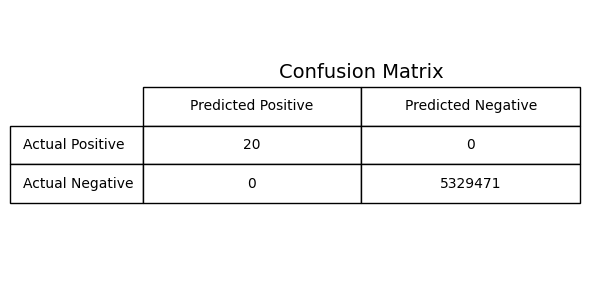

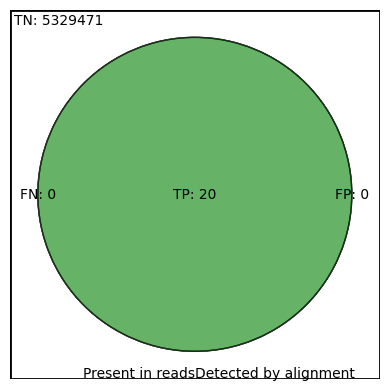

In [ ]:
unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, out = f"{plot_output_folder}/reference_metrics.txt", include_FPs_and_FNs_lists_in_output=True)
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'vcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'], 'vcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference.png")

unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_did_not_align_correctly'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']
unique_mcrs_df['number_of_reads_aligned_to_this_mcrs_item_that_aligned_incorrectly'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']

### Check reasons for reference false negatives - can take a long time for a large number of FNs 

In [ ]:
if check_reason_for_ref_fn:
    unexplainable_references = 0
    for header in metric_dictionary_reference['FNs']:
        print(f"Header {header}")
        did_not_align_anywhere = (read_df[read_df['vcrs_header'] == header])['FN_crude'].all()
        print(f"All did not align anywhere for {header}: {did_not_align_anywhere}")
        did_not_align_to_correct_position = (read_df[read_df['vcrs_header'] == header])['FN'].all()
        print(f"All did not align to correct mcrs for {header}: {did_not_align_to_correct_position}")
        multimapped = (read_df[read_df['vcrs_header'] == header])['multimapped'].all()
        print(f"All multimapped for {header}: {multimapped}")
        if not did_not_align_anywhere and not did_not_align_to_correct_position and not multimapped:
            unexplainable_references += 1

    if unexplainable_references > 0:
        print(f"Unexplainable references: {unexplainable_references}")
    else:
        print("All explainable!")

### Rename the columns as desired and save

In [ ]:
unique_mcrs_df.rename(columns={'received_an_aligned_read': 'mutation_detected_varseek', 'number_of_reads_aligned_to_this_item': 'DP_varseek', 'mutation_expression_prediction_error': 'mutation_expression_prediction_error_varseek', 'TP_crude': 'TP_varseek', 'FP_crude': 'FP_varseek', 'TN_crude': 'TN_varseek', 'FN_crude': 'FN_varseek', 'TP': 'TP_varseek_read_specific', 'FP': 'FP_varseek_read_specific', 'TN': 'TN_varseek_read_specific', 'FN': 'FN_varseek_read_specific'}, inplace=True)

In [ ]:
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)
read_df.to_csv(read_df_out_updated, index=False)